# [Optiver] Simple LGBM for beginner



This competition is to build the model to predict the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stockthe closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock.  
In my impression, many competitions of recent Kagglerecent Kaggle were for Image recognition or Natural language processing, and we haven't had Table competition for a long time.  



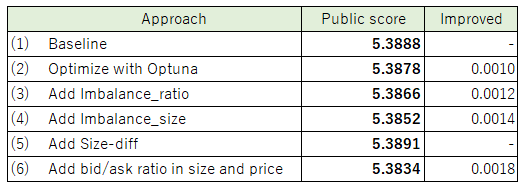

### Source
 - https://github.com/hyperopt/hyperopt
 - https://github.com/autonomio/talos
 - https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b

# 1. Baseline

First, just as a baseline, let's feed the training data into LightGBM and see how good public score is.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import optuna

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm

optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

from lightgbm import *
pd.set_option("display.max_columns", None)

In [2]:
df_train = pd.read_csv('../input/optiver-trading-at-the-close/train.csv')
df_test = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/test.csv')
sample_sub = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')
rev_target = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')

In [3]:
df_train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [4]:
def feature_cols(df) :
    cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id']]
    df = df[cols]    
    return df

In [5]:
df_train.fillna(0, inplace = True)
x_train = feature_cols(df_train.drop(columns='target'))
y_train = df_train['target'].values

In [6]:
lgbm_model = lgbm.LGBMRegressor(objective='mae', n_estimators=500, random_state=1234)
lgbm_model.fit(x_train, y_train)

LGBMRegressor(n_estimators=500, objective='mae', random_state=1234)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

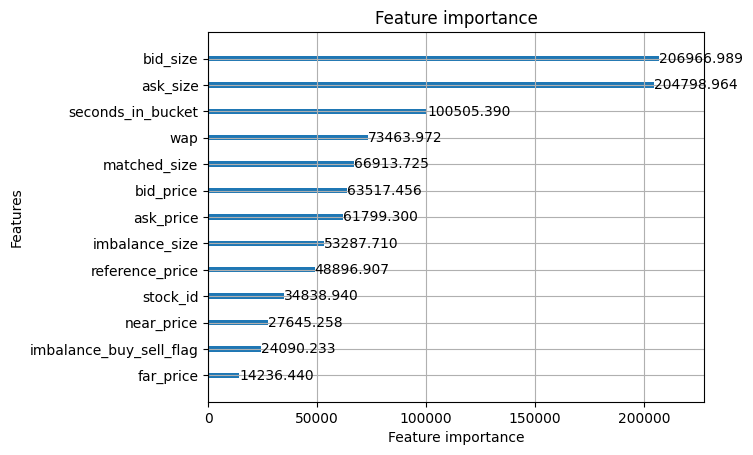

In [7]:
lgbm.plot_importance(lgbm_model, importance_type="gain")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

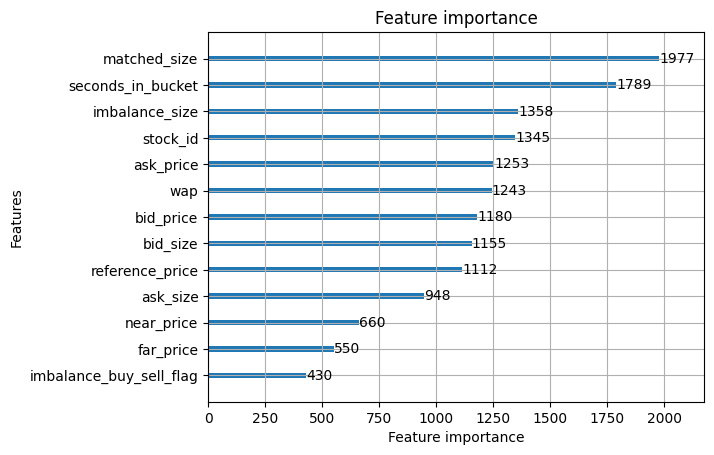

In [8]:
# splits means number of times a feature is used to split the data across all trees in the model
lgbm.plot_importance(lgbm_model, importance_type="split")

If you submit at this point, the public score will show **5.3888**, which is not so bad. Let's try some approaches from this baseline.


# 2. Optimize parameter with Optuna

Well, changing the approach here, let's see how the score is improved by optimizing the parameters. I used Optuna for optimization. As a result, Public score was improved to **5.3878**.


In [9]:
x = x_train.copy()
y = y_train.copy()

In [10]:
def objective(trial):
    params = {
        'random_seed':123,
        'n_estimators'    :trial.suggest_int('n_estimators', 300, 1000),
        'num_leaves'      :trial.suggest_int('num_leaves', 4, 32),
        'max_depth'       :trial.suggest_int("max_depth",1,10)}
            
    model = lgbm.LGBMRegressor(**params)
    model.fit(x,y)
    y_pred = model.predict(x)
    score = mean_absolute_error(y, y_pred)
    
    return score

In [11]:
#study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123))
#study.optimize(objective, n_trials=50) 
#study.best_params

Above optimization is Comment-out, since it takes a couple of hours to run this optimization。If you are curious, it may be interesting if you try to optimize various parameters after removing comment-out.

# 3. Add imbalance_size

Next, let's see how the score is improved by adding new features.  
As you can see the Light GBM "importance" in the above Section 1, not Price-related but Size-related features were regarded as important by LightGBM, thus try to create Size-related new features. First, let's create the ratio between imbalance_size and matched_size.  

The result is Puclic score was improved to **5.3866** as expected.  

In [12]:
#def pre_process1(df):
#    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
#    return df

# 4. Add imbalance_size

Then, let's try to add 2 more features related to imbalance between bid-size and ask-size, which will improve Public score to **5.3852**.  



For these features, I referred to below great notebook.   
https://www.kaggle.com/code/renatoreggiani/optv-lightgbm

In [13]:
#def pre_process1(df):
#       
#    df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
#    df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
#    
#    return df

In [14]:
# Original
# def pre_process1(df):
    
#     df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size'] 
#     #---> improve 0.0012
    
#     df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
#     df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
#     #---> improve 0.0014
    
#     df['bid_size_diff'] = df[["stock_id", "date_id", "bid_size"]].groupby(["stock_id","date_id"]).diff()
#     df['ask_size_diff'] = df[["stock_id", "date_id", "ask_size"]].groupby(["stock_id","date_id"]).diff()
#     #<--- "diff" doesn't work well
    
#     df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"])
#     df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])
#     #---> improve 0.0018
            
#     return df

In [15]:
# Edited
def pre_process1(df):
    
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size'] 
    #---> improve 0.0012
    
    df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
    df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
    #---> improve 0.0014
    
#     df['bid_size_diff'] = df[["stock_id", "date_id", "bid_size"]].groupby(["stock_id","date_id"]).diff()
#     df['ask_size_diff'] = df[["stock_id", "date_id", "ask_size"]].groupby(["stock_id","date_id"]).diff()
#     #<--- "diff" doesn't work well
    
#     df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"])
#     df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])
    #---> improve 0.0018
            
    return df

In [16]:
df_train = pre_process1(df_train)
df_train = feature_cols(df_train)
df_train.fillna(0, inplace = True)
df_train

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,imbalance_ratio,imbl_size1,imbl_size2
0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0.237708,0.754340,-0.615890
1,1,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0.101451,-0.728751,-0.815787
2,2,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0.166475,0.332935,-0.714567
3,3,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0.648061,-0.990340,-0.213547
4,4,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0.025058,0.948687,-0.951109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,0.086305,-0.816784,-0.841104
5237976,196,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,0.038041,0.374254,-0.926706
5237977,197,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,0.000000,-0.829388,-1.000000
5237978,198,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,0.010561,-0.684154,-0.979099


# 5. Try to use "diff" #

I tried to add Price diff for bid/ask-price of every time, since I remember the approach contributed to the improvement of score in Optiver's Volatility competition 2 years ago. However, the score unfortunatelly got worse to 5.3891, which is worse than Baseline. In my previous version, multiplication of Price-diff and Size-diff contributed to the score improvement, and hence I tried the same in this version also, but unfortunately doesn't work well. I am still considering how to utilize the "diff" of price or size, and would update this notebook if I come up with any good idea.  


# 6. Add bid/ask ratio in size and price

Approach to use "diff" didn't work well, but it seems imbalance-related new features work well, thus let's try to add ratio between bid and ask in price and size. The result is, public score was improved to **5.3834**, which is the best improvement so far. (For these new features, I refered to the above-mentioned link. Hoiwever, I didn't adopt the new features created by simple "plus" or "minus" of existing 2 features, since in my experiences I think those simple new features don't work. I guess simple plus/minus relationship between existing features are already considered by LGBM during study.)

- unnecessary calculations - calculating the same value multiple times. For example, the following code calculates the imbalance ratio twice:
  - df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
  - df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
  
- caching. Caching can be used to store the results of expensive calculations, so that they can be reused later without having to recalculate them. 


In [17]:
x_train = feature_cols(df_train.drop(columns='target'))
y_train = df_train['target'].values

In [18]:
# import numpy as np
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [500, 1000, 2000],
#     'num_leaves': [25, 50, 100],
#     'max_depth': [5, 7, 10]
# }

# grid_search = GridSearchCV(estimator=lgbm.LGBMRegressor(objective='mae'), param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)

# best_params = grid_search.best_params_

# # Create and train a new model with the best hyperparameters
# lgbm_model = lgbm.LGBMRegressor(objective='mae', **best_params)
# lgbm_model.fit(x_train, y_train)


In [19]:
# !pip install hyperopt --upgrade

In [20]:
# import hyperopt
# from lightgbm import LGBMRegressor

# def objective(params):
#     model = LGBMRegressor(objective='mae',
#                          n_estimators=params['n_estimators'],
#                          num_leaves=params['num_leaves'],
#                          max_depth=params['max_depth'])
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_train)
#     mae = mean_absolute_error(y, y_pred)
#     return mae

# search_space = {
#     'n_estimators': hyperopt.hp.choice('n_estimators', range(500, 1000)),
#     'num_leaves': hyperopt.hp.choice('num_leaves', range(20, 50)),
#     'max_depth': hyperopt.hp.choice('max_depth', range(5, 10))
# }

# trials = hyperopt.Trials()
# best_hyperparams = hyperopt.fmin(objective, search_space, algo=hyperopt.tpe.suggest, max_evals=13, trials=trials)

# best_hyperparams = trials.best_trial['misc']['vals']

# lgbm_model = LGBMRegressor(objective='mae',
#                             n_estimators=best_hyperparams['n_estimators'],
#                             num_leaves=best_hyperparams['num_leaves'],
#                             max_depth=best_hyperparams['max_depth'])
# lgbm_model.fit(x_train, y_train)

# y_pred = lgbm_model.predict(x_test)


In [21]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 20,  
    "max_bin": 512,
    "num_iterations": 1000,
    "force_col_wise": 'true'
}

lgbm_model = lgbm.LGBMRegressor(**params)
lgbm_model.fit(x_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              force_col_wise='true', learning_rate=0.005, max_bin=512,
              max_depth=8, metric=['l1', 'l2'], num_iterations=1000,
              num_leaves=20, objective='regression', task='train', verbose=0)

In [22]:
# import xgboost as xgb

# # Create an XGBoost regressor
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
#                              n_estimators=895,
#                              max_depth=7)

# # Train the model
# xgb_model.fit(x_train, y_train)

# xgb.plot_importance(xgb_model)

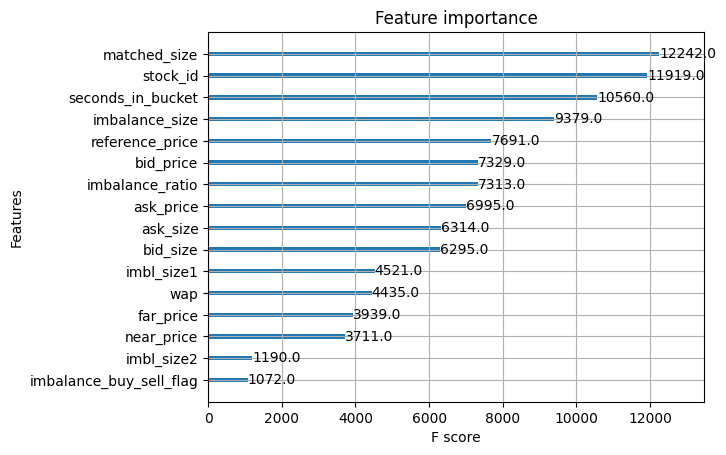

In [23]:
import xgboost as xgb
# Create an XGBoost regressor with the gpu_hist tree construction algorithm
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=895,
                             max_depth=7,
                             tree_method='gpu_hist')

# Train the model
xgb_model.fit(x_train, y_train)

# Plot the feature importances
xgb.plot_importance(xgb_model)

# Save the model
xgb_model.save_model('xgb_model.bin')
# Save as JSON file
xgb_model.save_model("xgb_model.json")
# Save as TXT file
xgb_model.save_model("xgb_model.txt")

In [24]:
# # Make predictions on the test data
# y_pred = xgb_model.predict(X_test)

In [25]:
# lgbm_model = lgbm.LGBMRegressor(objective='mae',
#                                 n_estimators=895,
#                                 num_leaves= 25,
#                                 max_depth= 7)
# lgbm_model.fit(x_train, y_train)

In [26]:
# from sklearn.ensemble import RandomForestRegressor

# rf_model = RandomForestRegressor(n_estimators=895,
#                                 max_depth= 8,criterion="squared_error",bootstrap=True)
# rf_model.fit(x_train, y_train)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

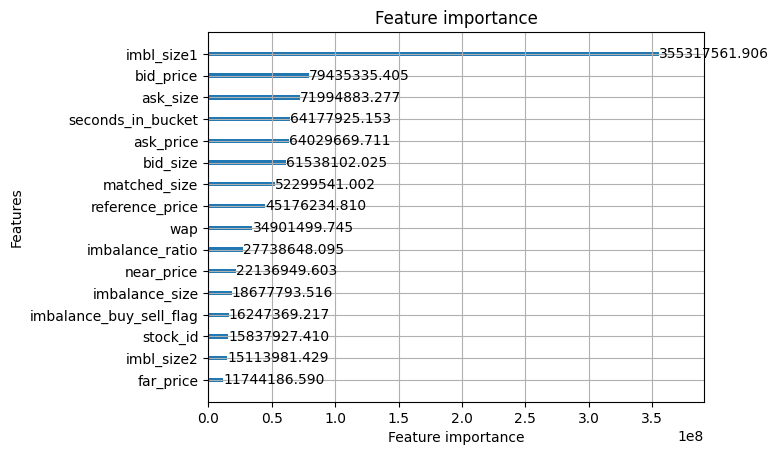

In [27]:
lgbm.plot_importance(lgbm_model, importance_type="gain")

# 7. Submission

As I said, this notebook is just a starter, and thus I'll submit at this point.   
In this competition, API provided by kaggle should be used.  

In [28]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [29]:
# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     test = pre_process1(test)
#     test_df = feature_cols(test)
#     sample_prediction['target'] = lgbm_model.predict(test_df)
#     env.predict(sample_prediction)
    
#     counter += 1

In [30]:
# basic edits
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    test = pre_process1(test)
    test_df = feature_cols(test)
    sample_prediction['target'] = xgb_model.predict(test_df)
    env.predict(sample_prediction)
    
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [31]:
sample_prediction

,row_id,target
0,480_540_0,-1.712622
1,480_540_1,2.254375
2,480_540_2,1.887509
3,480_540_3,-0.498100
4,480_540_4,-1.492800
...,...,...
195,480_540_195,-2.411422
196,480_540_196,-1.656932
197,480_540_197,1.871353
198,480_540_198,2.235493
